# 3D Multi-class Segmentation with SwinUNETR  (Muscle, Fat (subcut and internal), psoas)

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory



In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/data"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/data


## Setup transforms for training and validation

In [4]:
import datetime
import time

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=False,   # change-intermedouts 
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
#         SaveImaged(keys="image", meta_keys="image_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
#         SaveImaged(keys="label", meta_keys="label_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=250, b_min=0.0, b_max=1.0, clip=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"013123_MR/")

In [6]:
# data_dir = os.path.join(root_dir,"013123_MR/")
split_JSON = "dataset_MR04.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.78it/s]


In [7]:
data_dir = os.path.join(root_dir,"013123_MR/")
print(data_dir)
# help(val_loader)
# len(val_loader)

/home/adminbthomas/Downloads/data/013123_MR/


## Check data shape and visualize

image shape: torch.Size([1, 250, 171, 97]), label shape: torch.Size([1, 250, 171, 97])


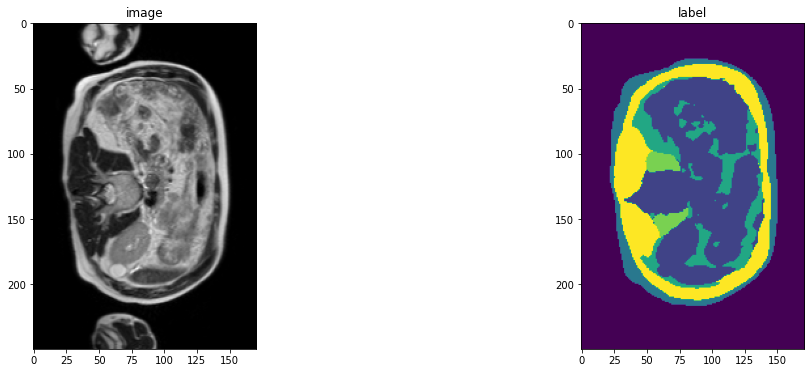

In [8]:
slice_map = {
    "A029_v4_T2W.nii.gz": 10,
    "A029_v4_T2W.nii.gz": 8,
    "A029_v4_T2W.nii.gz": 6
}
case_num = 3
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [9]:
#### os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:1")

# model = UNETR(
#     in_channels=1,
#     out_channels=6,
#     img_size=(96, 96, 16),
#     feature_size=16,
#     hidden_size=768,
#     mlp_dim=3072,
#     num_heads=12,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.0,
# ).to(device)
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=6,
    feature_size=24,
    use_checkpoint=True,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Execute a typical PyTorch training process

In [10]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
#         print(x.shape)
#         print(y.shape)
#         plt.figure("image", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.title("image")
#         plt.imshow(x[3,0,:,:,4].detach().cpu(), cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.title("label")
#         plt.imshow(y[3,0,:,:,4].detach().cpu())
#         plt.show()
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "TestMR08_swinUNetR_Jan24.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
        
    return global_step, dice_val_best, global_step_best


max_iterations = 30000
eval_num = 500
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
#     print('I am waiting....')
#     time.sleep(1)
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR08_swinUNetR_Jan24.pth")))

Validate (X / X Steps) (dice=X.X):   0%|                                                                                                                                     | 0/7 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Training (500 / 30000 Steps) (loss=1.53402):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:27<00:18,  6.22s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7160499606813703 Current Avg. Dice: 0.7160499606813703


Training (1000 / 30000 Steps) (loss=0.75375):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:22<00:49,  7.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7539287550108773 Current Avg. Dice: 0.7539287550108773


Training (1500 / 30000 Steps) (loss=0.94983):   8%|█████████▍                                                                                                       | 1/12 [00:18<03:23, 18.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7722577622958592 Current Avg. Dice: 0.7722577622958592


Training (2000 / 30000 Steps) (loss=0.78771):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:27<00:18,  6.21s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8830606596810477 Current Avg. Dice: 0.8830606596810477


Training (2500 / 30000 Steps) (loss=0.54346):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:22<00:49,  7.08s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8953525083405631 Current Avg. Dice: 0.8953525083405631


Training (3000 / 30000 Steps) (loss=0.53284):   8%|█████████▍                                                                                                       | 1/12 [00:18<03:21, 18.30s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9021795988082886 Current Avg. Dice: 0.9021795988082886


Training (3500 / 30000 Steps) (loss=0.49890):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:27<00:18,  6.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9021795988082886 Current Avg. Dice: 0.8988045794623238


Training (4000 / 30000 Steps) (loss=0.45361):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:22<00:49,  7.09s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9024529371942792 Current Avg. Dice: 0.9024529371942792


Training (4500 / 30000 Steps) (loss=0.35734):   8%|█████████▍                                                                                                       | 1/12 [00:18<03:18, 18.03s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9024529371942792 Current Avg. Dice: 0.901234643799918


Training (5000 / 30000 Steps) (loss=0.33686):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:27<00:18,  6.23s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9028736778667995 Current Avg. Dice: 0.9028736778667995


Training (5500 / 30000 Steps) (loss=0.38703):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:22<00:49,  7.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9088915756770543 Current Avg. Dice: 0.9088915756770543


Training (6000 / 30000 Steps) (loss=0.44710):   8%|█████████▍                                                                                                       | 1/12 [00:18<03:20, 18.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9088915756770543 Current Avg. Dice: 0.9059478129659381


Training (6500 / 30000 Steps) (loss=0.51605):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:27<00:18,  6.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9112934725625175 Current Avg. Dice: 0.9112934725625175


Training (7000 / 30000 Steps) (loss=0.29891):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:22<00:49,  7.03s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9112934725625175 Current Avg. Dice: 0.9054080929074969


Training (7500 / 30000 Steps) (loss=0.27020):   8%|█████████▍                                                                                                       | 1/12 [00:18<03:21, 18.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9112934725625175 Current Avg. Dice: 0.9098700029509408


Training (8000 / 30000 Steps) (loss=0.31289):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:27<00:18,  6.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9112934725625175 Current Avg. Dice: 0.9102385469845363


Training (8500 / 30000 Steps) (loss=0.33666):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:22<00:49,  7.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9112934725625175 Current Avg. Dice: 0.9090075748307365


Training (9000 / 30000 Steps) (loss=0.32959):   8%|█████████▍                                                                                                       | 1/12 [00:18<03:22, 18.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9113409774644035 Current Avg. Dice: 0.9113409774644035


Training (9500 / 30000 Steps) (loss=0.30151):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:27<00:18,  6.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9113409774644035 Current Avg. Dice: 0.9108193857329232


Training (10000 / 30000 Steps) (loss=0.47629):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9113409774644035 Current Avg. Dice: 0.9093949965068272


Training (10500 / 30000 Steps) (loss=0.30872):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:21, 18.29s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9127205865723746 Current Avg. Dice: 0.9127205865723746


Training (11000 / 30000 Steps) (loss=0.31049):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:26<00:18,  6.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9127205865723746 Current Avg. Dice: 0.9100736549922398


Training (11500 / 30000 Steps) (loss=0.36946):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9127205865723746 Current Avg. Dice: 0.908355712890625


Training (12000 / 30000 Steps) (loss=0.23392):   8%|█████████▎                                                                                                      | 1/12 [00:17<03:17, 17.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9127205865723746 Current Avg. Dice: 0.9110432182039533


Training (12500 / 30000 Steps) (loss=0.38755):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:27<00:18,  6.23s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9143681611333575 Current Avg. Dice: 0.9143681611333575


Training (13000 / 30000 Steps) (loss=0.32548):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9143681611333575 Current Avg. Dice: 0.9119859422956195


Training (13500 / 30000 Steps) (loss=0.28565):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:20, 18.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9143681611333575 Current Avg. Dice: 0.9080993022237506


Training (14000 / 30000 Steps) (loss=0.31168):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:27<00:18,  6.25s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9163652743612017 Current Avg. Dice: 0.9163652743612017


Training (14500 / 30000 Steps) (loss=0.31678):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9163652743612017 Current Avg. Dice: 0.9089745112827846


Training (15000 / 30000 Steps) (loss=0.32377):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:20, 18.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9163652743612017 Current Avg. Dice: 0.9092619674546378


Training (15500 / 30000 Steps) (loss=0.39784):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:26<00:18,  6.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9163652743612017 Current Avg. Dice: 0.9111426217215401


Training (16000 / 30000 Steps) (loss=0.24738):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9163652743612017 Current Avg. Dice: 0.911399245262146


Training (16500 / 30000 Steps) (loss=0.28913):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:19, 18.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9163652743612017 Current Avg. Dice: 0.9161610518183027


Training (17000 / 30000 Steps) (loss=0.29525):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:27<00:18,  6.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9163652743612017 Current Avg. Dice: 0.9153473377227783


Training (17500 / 30000 Steps) (loss=0.19254):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.08s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9169629216194153 Current Avg. Dice: 0.9169629216194153


Training (18000 / 30000 Steps) (loss=0.20152):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:18, 18.03s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9169629216194153 Current Avg. Dice: 0.9131580165454319


Training (18500 / 30000 Steps) (loss=0.30444):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:26<00:18,  6.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9169629216194153 Current Avg. Dice: 0.9162331819534302


Training (19000 / 30000 Steps) (loss=0.30956):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9169629216194153 Current Avg. Dice: 0.9130808881350926


Training (19500 / 30000 Steps) (loss=0.23199):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:19, 18.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9169629216194153 Current Avg. Dice: 0.9164826103619167


Training (20000 / 30000 Steps) (loss=0.25354):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:27<00:18,  6.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9183703064918518 Current Avg. Dice: 0.9183703064918518


Training (20500 / 30000 Steps) (loss=0.24351):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9188518013272967


Training (21000 / 30000 Steps) (loss=0.18368):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:18, 18.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9137325031416756


Training (21500 / 30000 Steps) (loss=0.32854):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:27<00:18,  6.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9116784504481724


Training (22000 / 30000 Steps) (loss=0.26345):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9150696992874146


Training (22500 / 30000 Steps) (loss=0.30580):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:19, 18.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9126392177173069


Training (23000 / 30000 Steps) (loss=0.20439):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:27<00:18,  6.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9176600405148098


Training (23500 / 30000 Steps) (loss=0.48099):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9129042114530291


Training (24000 / 30000 Steps) (loss=0.14834):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:18, 18.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9181649770055499


Training (24500 / 30000 Steps) (loss=0.29891):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:27<00:18,  6.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9135020204952785


Training (25000 / 30000 Steps) (loss=0.25291):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.908591628074646


Training (25500 / 30000 Steps) (loss=0.24131):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:18, 18.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9146001253809247


Training (26000 / 30000 Steps) (loss=0.27575):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:27<00:18,  6.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9154445954731533


Training (26500 / 30000 Steps) (loss=0.32728):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9167431592941284


Training (27000 / 30000 Steps) (loss=0.14044):   8%|█████████▎                                                                                                      | 1/12 [00:17<03:17, 17.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9161384701728821


Training (27500 / 30000 Steps) (loss=0.40165):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:27<00:18,  6.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9165854964937482


Training (28000 / 30000 Steps) (loss=0.22924):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9166445817266192


Training (28500 / 30000 Steps) (loss=0.30497):   8%|█████████▎                                                                                                      | 1/12 [00:18<03:19, 18.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.916619428566524


Training (29000 / 30000 Steps) (loss=0.29363):  75%|████████████████████████████████████████████████████████████████████████████████████                            | 9/12 [00:26<00:18,  6.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9160714660372052


Training (29500 / 30000 Steps) (loss=0.15713):  42%|██████████████████████████████████████████████▋                                                                 | 5/12 [00:22<00:49,  7.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9188518013272967 Current Avg. Dice: 0.9147598913737706


Training (29999 / 30000 Steps) (loss=0.37880): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:14<00:00,  1.19s/it]


<All keys matched successfully>

In [11]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.9189 at iteration: 20500


In [12]:
# 6062500/380133
# 12062500/731025
# 250*250*49
# 12062500/(250*250)

### Plot the loss and metric

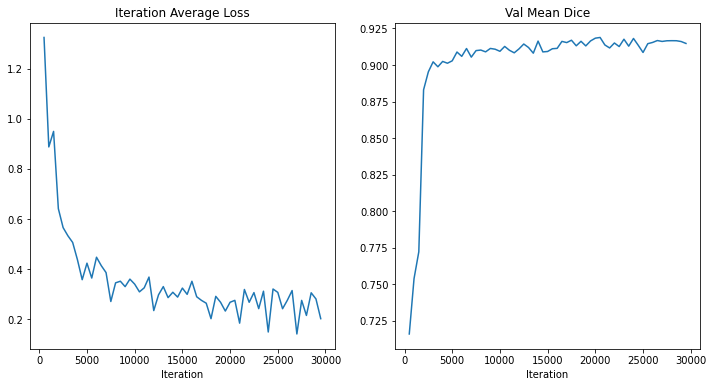

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

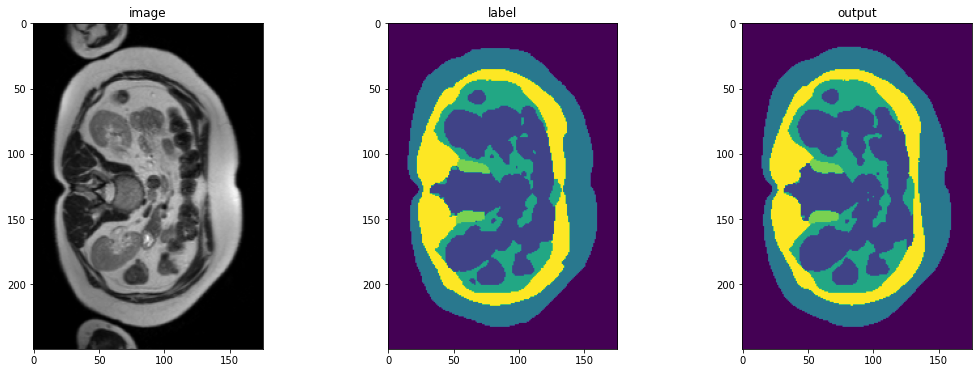

In [15]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR08_swinUNetR_Jan24.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
    )
    plt.show()
    

In [ ]:
# val_inputs.shape

### Inference on test images

In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)

In [18]:
import glob
from monai.data import Dataset
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs/img_setof10", "A043_v3*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 1.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=3600,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR08_Jan24", output_postfix="seg", resample=False, separate_folder=False),
])

In [ ]:
# print(data_dir)

2024-01-08 18:48:16,132 INFO image_writer.py:194 - writing: outMR08_Jan24/A043_v3_T2W_seg.nii.gz


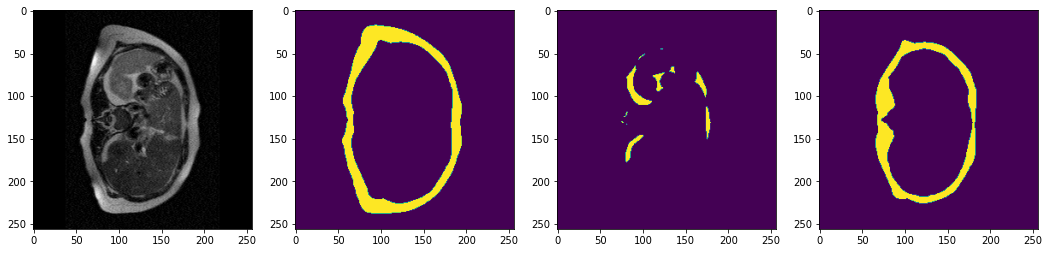

In [19]:
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "TestMR08_swinUNetR_Jan24.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(original_image[:, :, 8], cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(test_output[0].detach().cpu()[2, :, :, 8])
        plt.subplot(1, 4, 3)
        plt.imshow(test_output[0].detach().cpu()[3, :, :, 8])
        plt.subplot(1, 4, 4)
        plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
        plt.show()

In [ ]:
# # Testing code modified  (Based on validation block)

# from monai.transforms import LoadImage
# loader = LoadImage()

# model.load_state_dict(torch.load(
#     os.path.join(data_dir, "TestMR08_swinUNetR_Jan24.pth")))
# model.eval()

# with torch.no_grad():
#     for test_data in test_org_loader:
#         test_inputs = test_data["image"].to(device)
#         roi_size = (96, 96, 96)
#         sw_batch_size = 4
#         test_outputs = sliding_window_inference(
#             test_inputs, roi_size, sw_batch_size, model, overlap=0.8
#     )
# #     plt.figure("check", (18, 6))
# #     plt.subplot(1, 2, 1)
# #     plt.title("image")
# #     plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 40], cmap="gray")
# #     plt.subplot(1, 2, 2)
# #     plt.title("output")
# #     plt.imshow(
# #         torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, 40]
# #     )
# #     plt.show()      

In [ ]:
!tar -cvzf outMR08_Jan24.tar.gz outMR08_Jan24

In [ ]:
# !pwd

In [ ]:
# plt.figure("check", (18, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 20], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("output")
# plt.imshow(
#     torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, 20]
# )
# plt.show()

In [ ]:
# print(test_output[0].shape)

In [ ]:
# slno = 20
# plt.figure("check1", (18, 6))
# plt.imshow(original_image[:, :, slno], cmap="gray")
# plt.figure("check2", (18, 6))
# plt.subplot(3, 3, 1)
# plt.imshow(test_output[0].detach().cpu()[0, :, :, slno])
# plt.subplot(3, 3, 2)
# plt.imshow(test_output[0].detach().cpu()[1, :, :, slno])
# plt.subplot(3, 3, 3)
# plt.imshow(test_output[0].detach().cpu()[2, :, :, slno])
# plt.subplot(3, 3, 4)
# plt.imshow(test_output[0].detach().cpu()[3, :, :, slno])
# plt.subplot(3, 3, 5)
# plt.imshow(test_output[0].detach().cpu()[4, :, :, slno])
# plt.subplot(3, 3, 6)
# plt.imshow(test_output[0].detach().cpu()[5, :, :, slno])
# plt.subplot(3, 3, 7)
# plt.imshow(test_output[0].detach().cpu()[6, :, :, slno])
# plt.subplot(3, 3, 8)
# plt.imshow(test_output[0].detach().cpu()[7, :, :, slno])
# plt.subplot(3, 3, 9)
# plt.imshow(test_output[0].detach().cpu()[8, :, :, slno])
# plt.show()